In [1]:
import numpy as np
import sys
from os import listdir
from os.path import isfile, join
from tqdm import tqdm
import matplotlib.pyplot as plt

from site_utils import *
from model_utils import *
from data_utils import *
from model import *

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchnet.dataset import ListDataset
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
from torch.nn.parallel.data_parallel import DataParallel


In [2]:
device, num_workers, pin_memory, dtype = check_gpu()

Using GPU.


## Model Parameters

In [3]:
batch_size = 250
num_classes = 2
print_every = 5
split = 0.8

## Load Data

In [4]:
data = np.load('./datasets/dataset_400_maps.npy')
labels = np.load('./datasets/dataset_400_smoothlabels.npy')
weights = get_frequency(labels)
labels[labels > 0] = 1

100%|██████████| 10195/10195 [00:00<00:00, 138189.90it/s]


In [5]:
# Pull Out Testing Data
test_data = data[:500,:,:]
test_labels = labels[:500,:]
data = data[500:,:,:]
labels = labels[500:,:]

In [6]:
train_loader, val_loader = get_loaders_from_numpy(data, labels, batch_size, split=split)

X train:  torch.Size([7756, 512, 512])
Y train:  torch.Size([7756, 512])
X val:  torch.Size([1939, 512, 512])
Y val:  torch.Size([1939, 512])


## Define Loss Function

In [7]:
weight = torch.from_numpy(weights).to(device=device, dtype=dtype)
criterion = CrossEntropyLoss2d(size_average=False, weight=weight)

## Train Loop

In [8]:
def train(model, optimizer, lr_updater, results, epochs=5):
    
    for e in range(epochs):
        
        lr_updater.step()
        
        for t, (x,y) in enumerate(train_loader):
            model.train()
            
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            
            scores = model.forward(x)

            loss = criterion(scores,y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('Epoch %d/%d, loss = %.4f' % (e+1, epochs, loss.item()))
        train_metrics = check_metrics(train_loader, model, 'Training  ')
        val_metrics = check_metrics(val_loader, model, 'Validation')
        print()
        results[int(e+1)] = [loss.item(), train_metrics, val_metrics]

In [9]:
def train_model(model, model_name, hyperparams, device, epochs):
    '''
    
    Train Model
    
    This is a generic function to call the model's training function. 
    
    '''

    print('Beginning Training for: ', model_name)
    print('------------------------------------')
    
    results = {}
    
    if torch.cuda.device_count() > 1: 
        print("Using ", torch.cuda.device_count(), " GPUs.")
        print('------------------------------------')
        model = DataParallel(model)
        
    model = model.to(device=device)
    
    optimizer = optim.Adam(model.parameters(), betas=hyperparams['betas'], lr=hyperparams['learning_rate'], weight_decay=hyperparams['L2_reg'])
    
    lr_updater = lr_scheduler.StepLR(optimizer, hyperparams['lr_decay_epochs'], hyperparams['lr_decay'])
    
    train(model, optimizer, lr_updater, results, epochs=epochs)
    
    plot_results(results, model_name ,save=True)
    np.save(model_name, results)
    
    return results

Beginning Training for:  cnn4_full_xSmooth3
------------------------------------
Using  2  GPUs.
------------------------------------
Epoch 1/50, loss = 455.0405
Training   ==> Precision: 0.0992 | Recall: 0.4413 | F1: 0.16 | Accuracy: 0.600
Validation ==> Precision: 0.0974 | Recall: 0.4369 | F1: 0.16 | Accuracy: 0.599

Epoch 2/50, loss = 322.6078
Training   ==> Precision: 0.1017 | Recall: 0.4859 | F1: 0.17 | Accuracy: 0.579
Validation ==> Precision: 0.0982 | Recall: 0.4761 | F1: 0.16 | Accuracy: 0.574

Epoch 3/50, loss = 299.8397
Training   ==> Precision: 0.1053 | Recall: 0.5231 | F1: 0.18 | Accuracy: 0.569
Validation ==> Precision: 0.1014 | Recall: 0.5097 | F1: 0.17 | Accuracy: 0.564

Epoch 4/50, loss = 298.4576
Training   ==> Precision: 0.1078 | Recall: 0.5490 | F1: 0.18 | Accuracy: 0.563
Validation ==> Precision: 0.1023 | Recall: 0.5283 | F1: 0.17 | Accuracy: 0.556

Epoch 5/50, loss = 276.0212
Training   ==> Precision: 0.1091 | Recall: 0.5626 | F1: 0.18 | Accuracy: 0.559
Validation 

Epoch 44/50, loss = 93.9268
Training   ==> Precision: 0.5239 | Recall: 0.7415 | F1: 0.61 | Accuracy: 0.918
Validation ==> Precision: 0.3191 | Recall: 0.4424 | F1: 0.37 | Accuracy: 0.869

Epoch 45/50, loss = 96.1131
Training   ==> Precision: 0.5442 | Recall: 0.7288 | F1: 0.62 | Accuracy: 0.923
Validation ==> Precision: 0.3321 | Recall: 0.4308 | F1: 0.38 | Accuracy: 0.875

Epoch 46/50, loss = 90.4267
Training   ==> Precision: 0.5530 | Recall: 0.7215 | F1: 0.63 | Accuracy: 0.925
Validation ==> Precision: 0.3374 | Recall: 0.4234 | F1: 0.38 | Accuracy: 0.878

Epoch 47/50, loss = 90.7643
Training   ==> Precision: 0.5316 | Recall: 0.7735 | F1: 0.63 | Accuracy: 0.920
Validation ==> Precision: 0.3195 | Recall: 0.4595 | F1: 0.38 | Accuracy: 0.868

Epoch 48/50, loss = 101.7903
Training   ==> Precision: 0.5375 | Recall: 0.7883 | F1: 0.64 | Accuracy: 0.922
Validation ==> Precision: 0.3191 | Recall: 0.4649 | F1: 0.38 | Accuracy: 0.867

Epoch 49/50, loss = 101.7547
Training   ==> Precision: 0.5419 | 

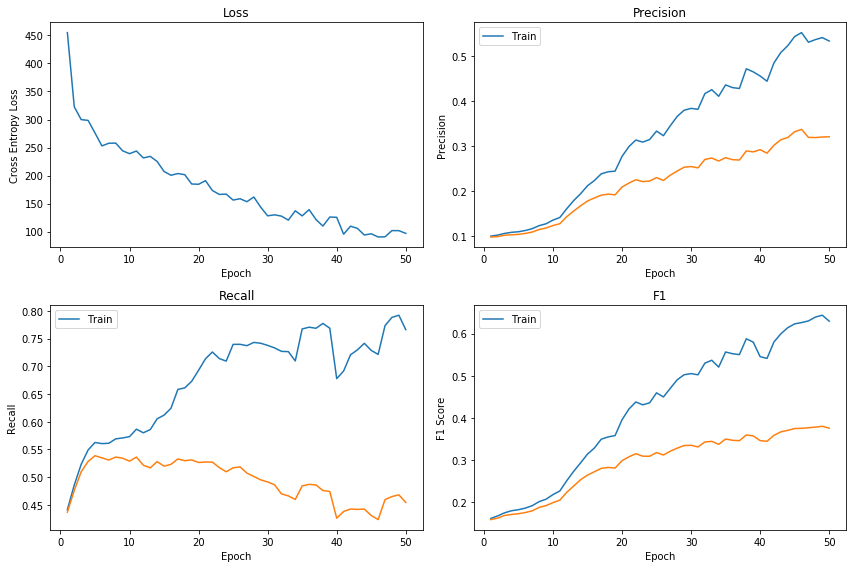

In [10]:
epochs = 50
name = 'cnn4_full_xSmooth3'

hyperparams = {}

hyperparams['betas'] = (0.9, 0.99)
hyperparams['L2_reg'] = 5e-2

hyperparams['learning_rate'] = 0.001
hyperparams['lr_decay_epochs'] = 55
hyperparams['lr_decay'] = 0.8

model = ConvNet4()

hyp = name + '_hyper.npy'
mod = name + '.pt'

results = train_model(model, name, hyperparams, device, epochs)
np.save(hyp, hyperparams)
torch.save(model.state_dict(), name+'.pt')

In [25]:
def plot_results2(results, file_name='default', save=False):
    '''
    
    Plot Results
    
    
    '''
    L = sorted(results.items())
    e, Z = zip(*L)
    
    loss, train_precision, train_recall, train_f1, train_acc = [], [], [], [], []
    val_precision, val_recall, val_f1, val_acc = [], [], [], []
    
    val_flag = False
    
    for i,z in enumerate(Z):
        loss.append(z[0])
        train_metrics, val_metrics = z[1], z[2]
        
        train_precision.append(train_metrics['precision'])
        train_recall.append(train_metrics['recall'])
        train_f1.append(train_metrics['F1 score'])
        train_acc.append(train_metrics['accuracy'])
        
        if val_metrics:
            val_flag = True
            val_precision.append(val_metrics['precision'])
            val_recall.append(val_metrics['recall'])
            val_f1.append(val_metrics['F1 score'])
            val_acc.append(val_metrics['accuracy'])        
    
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
                
    ax1.plot(e, train_acc, label='Train Loss')
    ax1.set_title('Base Pair Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    
    ax2.plot(e, train_precision, label='Train')
    ax2.legend(loc='upper left')
    ax2.set_title('Precision')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Precision')
    
    ax3.plot(e, train_recall, label='Train')
    ax3.legend(loc='upper left')
    ax3.set_title('Recall')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Recall')

    ax4.plot(e, train_f1, label='Train')
    ax4.legend(loc='upper left')
    ax4.set_title('F1')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('F1 Score')
    
    if val_flag:
        ax1.plot(e, val_acc, label='Val')
        ax1.legend(loc='lower right')
        ax2.plot(e, val_precision, label='Val')
        ax2.legend(loc='upper left')
        ax3.plot(e, val_recall, label='Val')
        ax3.legend(loc='upper left')
        ax4.plot(e, val_f1, label='Val')
        ax4.legend(loc='upper left')
    
    fig.set_size_inches(12, 8, forward=True)
    plt.tight_layout()
    
    if save:
        plt.savefig(file_name+'.png',dpi=300)
    plt.show()



In [ ]:
epochs = 200
name = 'cnn2_full_xSmooth1'

model = ConvNet2()

hyp = name + '_hyper.npy'
mod = name + '.pt'

results = train_model(model, name, hyperparams, device, epochs)
np.save(hyp, hyperparams)
torch.save(model.state_dict(), name+'.pt')

In [14]:
results_2 = np.load('results/cnn4_full_xSmooth1.npy').item()

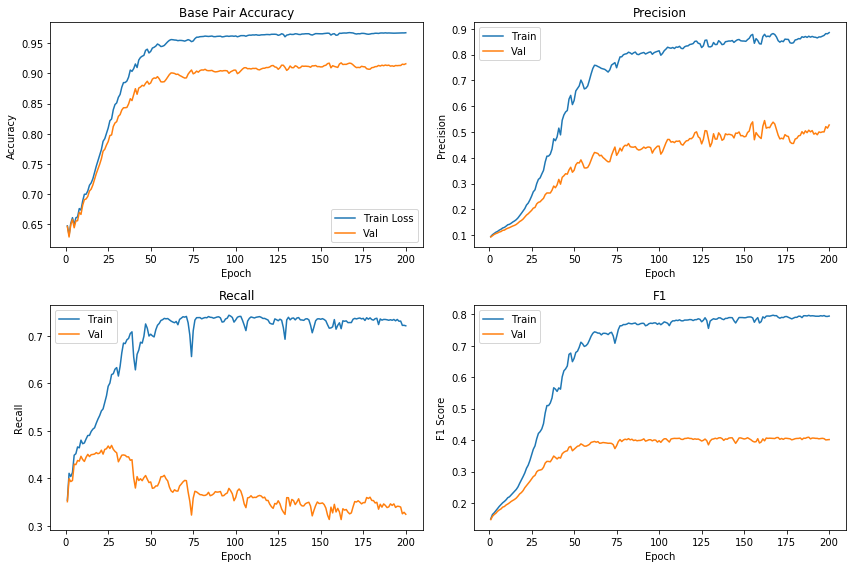

In [27]:
plot_results2(results_2, file_name='paper_results', save=True)